## Loading data from github![img_rn.png](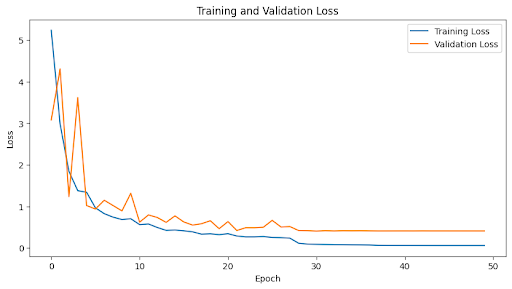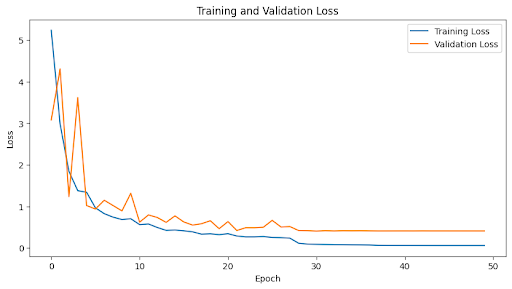)


In [27]:
!git clone https://github.com/sjainer/CIGIN_CS598_data

Cloning into 'CIGIN_CS598_data'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 5.73 MiB | 14.41 MiB/s, done.


# Introduction

In computational chemistry and molecular modeling, predicting solvation free energies is crucial for various scientific fields, from drug design to environmental science. It falls under molecular property prediction, aiming to estimate a molecule's property based on its structure and interactions. Accurate predictions are vital for drug discovery, aiding in identifying effective pharmaceuticals, and for environmental studies, guiding pollutant transport and remediation strategies. Despite its significance, the problem is challenging due to complex molecular interactions and vast chemical space. State-of-the-art methods, like Message Passing Neural Networks (MPNNs), use deep learning to model these interactions, but accuracy and interpretability can still be improved.

* CIGIN Research Paper:

The paper proposes a novel approach to solvation free energy prediction called the Chemically Interpretable Graph Interaction Network (CIGIN). The key innovation of the method lies in its three-phase architecture, comprising message passing, interaction, and prediction phases, tailored specifically for modeling molecular interactions. Unlike previous methods, CIGIN incorporates detailed atom and bond features extracted from molecular structures, enabling a more nuanced representation of solute-solvent interactions.

The effectiveness of the proposed method is demonstrated through comprehensive experimentation on the Minnesota Solvation Database, which contains 3037 experimental free energies of solvation for 790 unique solutes in 92 solvents. The results showcase superior performance compared to baseline models, with a reduced root mean square error (RMSE) in predicting solvation free energies. Specifically, the proposed CIGIN model, incorporating Chemically Interpretable Graph Interaction Network, achieved an RMSE of 0.57 kcal/mol on the test set, outperforming baseline models by a significant margin. Moreover, the model's interpretability is highlighted through detailed analysis of interaction maps, providing insights into the underlying molecular mechanisms driving solvation processes. These findings demonstrate the efficacy and interpretability of the proposed approach in addressing the challenging task of solvation free energy prediction.

n terms of contribution to the research regime, the paper significantly advances the field of solvation free energy prediction by introducing a novel computational framework that combines deep learning with chemically interpretable features. By addressing the limitations of existing methods and achieving state-of-the-art performance, CIGIN opens up new avenues for accurately modeling and understanding molecular solvation phenomena, with far-reaching implications for various scientific and industrial applications.


# Scope of Reproducibility:

List hypotheses from the paper:


1.   Hypothesis 1: The improved CIGIN variant with a different MPNN implementation tailored for this use case gives the best result for predicting the solvation free energies of solute solvent combinations from the Minnes.. dataset.
2.   Hypothesis 2: The baseline CIGIN model with a non-optimized MPNN resulted in slightly lesser performance metric compared to the above CIGIN variant.

Below is the architecture of CIGIN model proposed in the research paper.

![CIGIN Architecture](https://drive.google.com/uc?export=view&id=1lEL0yb20YTP1zBuqxEL7ByuVvquchZu_) Reference: https://doi.org/10.1609/aaai.v34i01.5433

The CIGIN architecture consists of three phases: the message passing phase, the interaction phase, and the prediction phase.

<b>Message Passing Phase:</b> <br>In this phase, molecules are represented as graphs, with atoms as nodes and bonds as edges. Each atom and bond is characterized by a set of features. The state of each node is updated iteratively over several time steps using message passing. At each time step, messages are passed between neighboring nodes, and the state of each node is updated based on these messages. This phase typically involves message functions and vertex update functions, implemented as fully connected layers in a neural network. The final feature vector for each node is obtained using a gather layer.

<b>Interaction Phase:</b> <br>In this phase, pairwise interactions between solute-solvent atoms are modeled in an interaction map. The interaction map computes the interactions between solute and solvent features, producing a matrix that represents the interactions between all pairs of solute and solvent atoms. This phase utilizes a function to compute interaction values for each pair of atoms, typically implemented as a neural network layer.

<b>Prediction Phase: </b><br>
In the final phase, the predicted solvation free energy is obtained. The outputs of the message passing and interaction phases are combined atom-wise, and a readout layer is used to combine the feature vectors across all atoms. This readout layer aggregates the features in a manner invariant to graph isomorphism, producing a one-dimensional vector. This vector is then passed through fully connected layers to predict the solvation free energy. The choice of readout layer can vary, with options such as sum pooling or a set2set layer.




In [ ]:
# define dirs to workspace and data
cigin_dr = '/content/gdrive/My Drive/CIGIN'

# Methodology


In [ ]:
# import  packages you need
!pip install dgl
!pip install rdkit
!pip install pubchempy
import numpy as np
import pandas as pd
from google.colab import drive
import torch
import dgl
import rdkit
from dgl import DGLGraph
from dgl.nn.pytorch import Set2Set, NNConv, GATConv
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors as rdDesc
from rdkit import RDLogger
from rdkit import rdBase
import warnings
import os
import argparse
from tqdm import tqdm
from collections import OrderedDict
from copy import deepcopy
import random
import pickle
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pubchempy as pcp
from urllib.request import urlopen
from urllib.parse import quote
from tqdm import tqdm
import time


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 13.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


##  Data
<b>Data Source:</b><br> The data used in this project is sourced from the Minnesota Solvation Database, which contains experimental free energies of solvation or transfer free energies of various solutes in different solvents. The database comprises 3037 entries of solvation data for 790 unique solutes in 92 solvents. The original dataset contains solvation energy of 3037 samples. In our work, we only consider neutral solutes, which removes 249 charged solutes. Additionally entries corresponding to transfer free energy are removed, so finally 2530 unique solute and solvent pairs are in our dataset.

The dataset is publicly available and can be accessed through the provided DOI link: https://doi.org/10.13020/3eks-j059. Further details about the database, including its availability and usage guidelines, are accessible on the website: https://conservancy.umn.edu/handle/11299/213300.

<b>Preprocessing:</b></br>
The dataset obtained from the mentioned source includes the necessary data; however, to analyze solute-solvent interactions, the solute and solvent molecules need to be converted into a graph structure. In this process, atoms are represented as nodes, and chemical bonds are represented as edges. To achieve this, we obtained the SMILES representation for each solute and solvent molecule.
<h3>Data process</h3>

<ol>
    <li>As mentioned, we process the data by removing the charged samples and by removing the samples with transfer free energy </li>
    <li> We then obtained SMILES for solutes and solvents </li>
    <li> We save all the curated data in csv format </li>

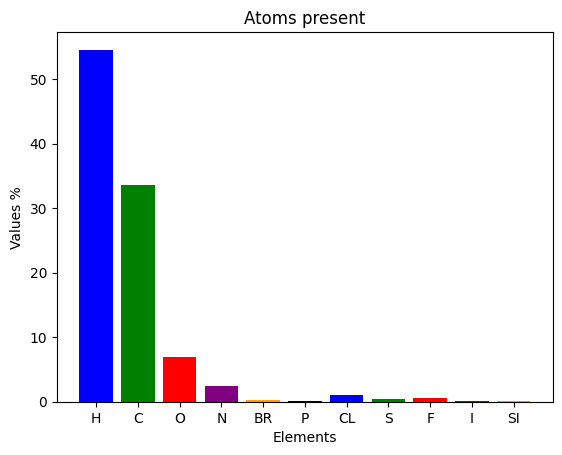

In [28]:
#Code used to obtain SMILE strings for each of the solute and solvent molecules using an api and pubchempy package.
#The obtained results are cleaned and saved as a csv file which is later used for training and testing purposes.

# dir and function to load raw data
raw_data_dir = '/content/CIGIN_CS598_data/data/'
raw_data = pd.read_csv(raw_data_dir+'MNSol_Acquired_Dataset.csv', sep=";")

filtered = []

df = pd.read_csv(raw_data_dir+'alldata.csv')

element_dict = {}

def parse_atoms(atom_string, ans_dict):
    if len(atom_string) == 0:
        return ans_dict

    char_start = 0
    element = ''

    rep = ''

    while char_start < len(atom_string) and atom_string[char_start].isalpha():
        element += atom_string[char_start]
        char_start += 1

    while char_start < len(atom_string) and not atom_string[char_start].isalpha():
        rep += atom_string[char_start]
        char_start += 1

    if element in ans_dict:
        ans_dict[element] += int(rep)
    else:
        ans_dict[element] = int(rep)

    return parse_atoms(atom_string[char_start:], ans_dict)

df = pd.read_csv(raw_data_dir+'alldata.csv')
for index, row in df.iterrows():
    formula = row["Formula"]
    parse_atoms(formula, element_dict)
percent_dict = {key: (value / sum(element_dict.values())) * 100 for key, value in element_dict.items()}

# Get the Keys and store them in a list
labels = list(element_dict.keys())

# Get the Values and store them in a list
values = list(percent_dict.values())

colors = ['blue', 'green', 'red', 'purple', 'orange', 'black']  # Add more colors as needed

plt.bar(labels, values, color=colors)


# Add title and labels
plt.title('Atoms present')
plt.xlabel('Elements')
plt.ylabel('Values %')

# Show the plot
plt.show()

# Commenting the code below as data is acquired and stored in the drive as part of preprocessing step!

# for index, row in df.iterrows():
#     charge_value = row["Charge"]
#     type_ = row["type"]

#     if charge_value != 0 or type_ != 'abs':
#         continue

#     filtered.append({'Solute': row['SoluteName'], 'Solvent': row['Solvent'], 'DeltaGsolv': row['DeltaGsolv']})

# print(f'total samples: {len(filtered)}')

# def CIRconvert(ids):
#     try:
#         url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
#         ans = urlopen(url).read().decode('utf8')
#         return ans
#     except:
#         return 'Did not work'

# def get_smile(compound_name):
#     results = pcp.get_compounds(compound_name, 'name')
#     if len(results) == 1:
#         compund = pcp.Compound.from_cid(results[0].cid)
#         return compund.isomeric_smiles

#     else:
#         return CIRconvert(compound_name)

# from urllib.request import urlopen
# from urllib.parse import quote
# from tqdm import tqdm
# import time

# i = 1

# for idx in tqdm(range(len(filtered))):
#     i += 1
#     filtered[idx]['SoluteSmiles'] = get_smile(filtered[idx]['Solute'])
#     filtered[idx]['SolventSmiles'] = get_smile(filtered[idx]['Solvent'])
#     time.sleep(1)

#     if i % 900 == 0:
#         time.sleep(600)

# counter = 0
# pure = []
# for element in filtered:
#     add = True
#     for key, value in element.items():
#         if type(value) == str and 'work' in value:
#             counter += 1
#             add = False
#             break
#     if add:
#         pure.append(element)

# df = pd.DataFrame(pure)

# Save the DataFrame to a CSV file
# df.to_csv('cleaned_data.csv', index=False)






The above figure shows the presence of elements in the solute and solvent molecules. The high percentage of hydrogen justifies why the authors and we have not considered Hydrogen atoms while forming molecule graphs.

Dataset Size: 2328


Top 5 most frequently used solutes:
      Solute  Count_of_samples
     ethanol                62
     toluene                59
  2-butanone                57
    n-octane                51
nitromethane                50


Most used solvent: water




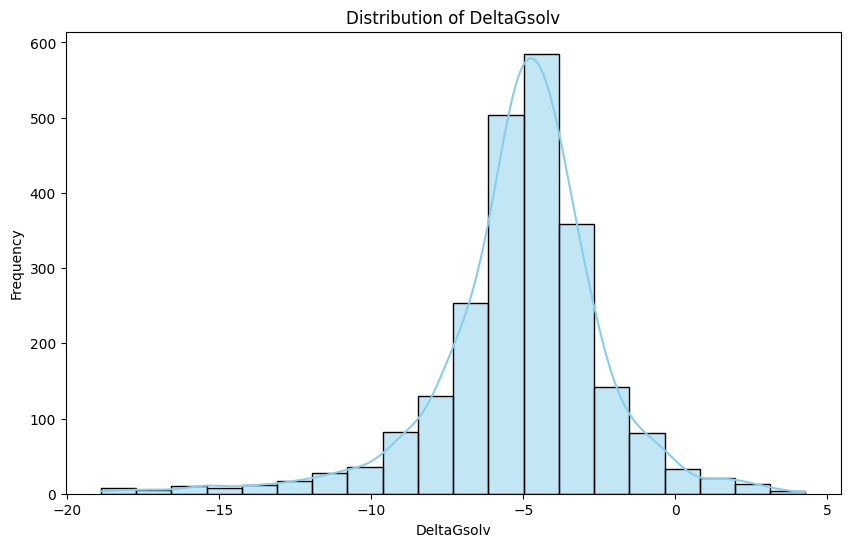

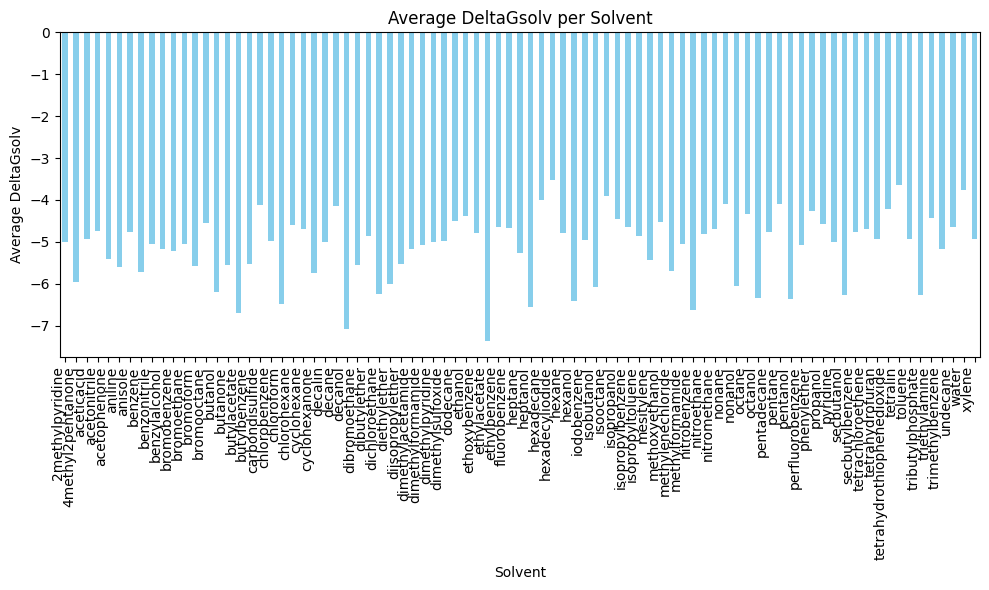

In [ ]:
# calculate statistics
def calculate_stats(raw_data):
  sample_size = len(raw_data)
  print("Dataset Size:", sample_size)
  print("\n")
  top_solute_frequency = raw_data['Solute'].value_counts().sort_values(ascending=False).head(5)
  top_solute_frequency = top_solute_frequency.rename_axis('Solute').reset_index(name='Count_of_samples')
  print("Top 5 most frequently used solutes:")
  print(top_solute_frequency.to_string(index=False))
  print("\n")
  # Find the most used solvent
  most_used_solvent = raw_data['Solvent'].mode()[0]
  print("Most used solvent:", most_used_solvent)
  print("\n")
  # DeltaGsolv Distribution
  plt.figure(figsize=(10, 6))
  sns.histplot(raw_data['DeltaGsolv'], kde=True, color='skyblue', bins=20)
  plt.title('Distribution of DeltaGsolv')
  plt.xlabel('DeltaGsolv')
  plt.ylabel('Frequency')
  plt.show()
  print("\n")
  # Calculate the average DeltaGsolv per solvent
  avg_delta_per_solute = raw_data.groupby('Solvent')['DeltaGsolv'].mean()

  # Plot the average DeltaGsolv per solvent
  plt.figure(figsize=(10, 6))
  avg_delta_per_solute.plot(kind='bar', color='skyblue')
  plt.title('Average DeltaGsolv per Solvent')
  plt.xlabel('Solvent')
  plt.ylabel('Average DeltaGsolv')
  plt.xticks(rotation=90, ha='right')
  plt.tight_layout()
  plt.show()
  print("\n")

calculate_stats(raw_data)

In [ ]:
# Split the data into features (X) and target variable (y)
X = raw_data.drop(columns=['DeltaGsolv'])  # Features
y = raw_data['DeltaGsolv']  # Target variable

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Save the train, validation, and test sets to CSV files
train_data = pd.concat([X_train, y_train], axis=1)
valid_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# train_data.to_csv(raw_data_dir+'train_data.csv', index=False)
# valid_data.to_csv(raw_data_dir+'validation_data.csv', index=False)
# test_data.to_csv(raw_data_dir+'test_data.csv', index=False)

Solute :  2-hexanone


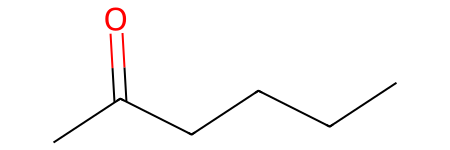

In [ ]:
train_df = pd.read_csv(raw_data_dir+'train_data.csv')
valid_df = pd.read_csv(raw_data_dir+'validation_data.csv')
test_df = pd.read_csv(raw_data_dir+'test_data.csv')

random_sample = train_df.sample(n=1, random_state=42)
SoluteSMILES = random_sample['SoluteSMILES'].iloc[0]
SolventSMILES = random_sample['SolventSMILES'].iloc[0]
print("Solute : ", random_sample['Solute'].iloc[0])
Chem.MolFromSmiles(SoluteSMILES)



Solvent :  perfluorobenzene


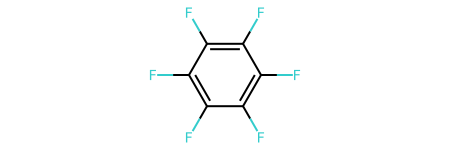

In [ ]:
print("Solvent : ", random_sample['Solvent'].iloc[0])
Chem.MolFromSmiles(SolventSMILES)

## EXPERIMENT 1 TO TEST HYPOTHESIS 1

The following data preprocessing functions are used to extract necessary features in desired data formats to train the neural network.

In [ ]:
def collate(samples):
    """Collates a list of samples into a batch for processing.
    Batches solute and solvent graphs and computes length matrices.
    Returns batched graphs, length matrices, and labels."""
    solute_graphs, solvent_graphs, labels = map(list, zip(*samples))
    solute_graphs = dgl.batch(solute_graphs)
    solvent_graphs = dgl.batch(solvent_graphs)
    solute_len_matrix = get_len_matrix(solute_graphs.batch_num_nodes().numpy())
    solvent_len_matrix = get_len_matrix(solvent_graphs.batch_num_nodes().numpy())
    return solute_graphs, solvent_graphs, solute_len_matrix, solvent_len_matrix, labels


class Dataclass(Dataset):
    """Custom dataset class for processing input data.
      Processes SMILES strings into molecular graphs.
    Returns samples containing solute, solvent graphs, and labels."""
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        solute = self.dataset.loc[idx]['SoluteSMILES']
        mol = Chem.MolFromSmiles(solute)
        mol = Chem.AddHs(mol)
        solute = Chem.MolToSmiles(mol)
        solute_graph = get_graph_from_smile(solute)

        solvent = self.dataset.loc[idx]['SolventSMILES']
        mol = Chem.MolFromSmiles(solvent)
        mol = Chem.AddHs(mol)
        solvent = Chem.MolToSmiles(mol)

        solvent_graph = get_graph_from_smile(solvent)
        delta_g = self.dataset.loc[idx]['DeltaGsolv']
        return [solute_graph, solvent_graph, [delta_g]]

def one_of_k_encoding(x, allowable_set):
    """Encodes categorical variable `x` into a one-hot vector.
        Handles values not in the allowable set."""
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]

    return list(map(lambda s: x == s, allowable_set))


def get_len_matrix(len_list):
    """Generates a length matrix from a list of lengths.
        Indicates the presence of nodes in graphs."""
    len_list = np.array(len_list)
    max_nodes = np.sum(len_list)
    curr_sum = 0
    len_matrix = []
    for l in len_list:
        curr = np.zeros(max_nodes)
        curr[curr_sum:curr_sum + l] = 1
        len_matrix.append(curr)
        curr_sum += l
    return np.array(len_matrix)

def get_atom_features(atom, stereo, features, explicit_H=False):
    """
    Method that computes atom level features from rdkit atom object
    :param atom:
    :param stereo:
    :param features:
    :param explicit_H:
    :return: the node features of an atom
    """
    possible_atoms = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'Si']
    atom_features = one_of_k_encoding_unk(atom.GetSymbol(), possible_atoms)
    atom_features += one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1])
    atom_features += one_of_k_encoding_unk(atom.GetNumRadicalElectrons(), [0, 1])
    atom_features += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6])
    atom_features += one_of_k_encoding_unk(atom.GetFormalCharge(), [-1, 0, 1])
    atom_features += one_of_k_encoding_unk(atom.GetHybridization(), [
        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D])
    atom_features += [int(i) for i in list("{0:06b}".format(features))]

    if not explicit_H:
        atom_features += one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])

    try:
        atom_features += one_of_k_encoding_unk(stereo, ['R', 'S'])
        atom_features += [atom.HasProp('_ChiralityPossible')]
    except Exception as e:

        atom_features += [False, False
                          ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(atom_features)


def get_bond_features(bond):
    """
    Method that computes bond level features from rdkit bond object
    :param bond: rdkit bond object
    :return: bond features, 1d numpy array
    """

    bond_type = bond.GetBondType()
    bond_feats = [
        bond_type == Chem.rdchem.BondType.SINGLE, bond_type == Chem.rdchem.BondType.DOUBLE,
        bond_type == Chem.rdchem.BondType.TRIPLE, bond_type == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]
    bond_feats += one_of_k_encoding_unk(str(bond.GetStereo()), ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])

    return np.array(bond_feats)


def get_graph_from_smile(molecule_smile):
    """
    Method that constructs a molecular graph with nodes being the atoms
    and bonds being the edges.
    :param molecule_smile: SMILE sequence
    :return: DGL graph object, Node features and Edge features
    """

    G = DGLGraph()
    molecule = Chem.MolFromSmiles(molecule_smile)
    features = rdDesc.GetFeatureInvariants(molecule)

    stereo = Chem.FindMolChiralCenters(molecule)
    chiral_centers = [0] * molecule.GetNumAtoms()
    for i in stereo:
        chiral_centers[i[0]] = i[1]

    G.add_nodes(molecule.GetNumAtoms())
    node_features = []
    edge_features = []
    for i in range(molecule.GetNumAtoms()):

        atom_i = molecule.GetAtomWithIdx(i)
        atom_i_features = get_atom_features(atom_i, chiral_centers[i], features[i])
        node_features.append(atom_i_features)

        for j in range(molecule.GetNumAtoms()):
            bond_ij = molecule.GetBondBetweenAtoms(i, j)
            if bond_ij is not None:
                G.add_edges(i, j)
                bond_features_ij = get_bond_features(bond_ij)
                edge_features.append(bond_features_ij)

    G.ndata['x'] = torch.from_numpy(np.array(node_features))
    G.edata['w'] = torch.from_numpy(np.array(edge_features))

    return G


##   Model

#### Model Architecture
  * GatherModel: A message passing neural network (MPNN) based on the paper "Neural Message Passing for Quantum Chemistry." It consists of multiple message passing steps using NNConv layers and linear transformations.
  * CIGINModel: Combines two instances of the GatherModel for solute and solvent molecules, followed by interaction and prediction phases. It uses Set2Set pooling to aggregate node features and linear layers for prediction.

Here's a tabular structure explaining the input-output dimensions for each layer in the provided models:

| Layer              | Input Dimensions                         | Output Dimensions                        |
|--------------------|------------------------------------------|------------------------------------------|
| `GatherModel`      | Node feature: (B1, D1)<br>Edge feature: (B2, D2) | Node feature: (B1, D1)<br> |
| `Linear` (lin0)    | Node feature: (B1, D1)                   | Node feature: (B1, node_hidden_dim)      |
| `Set2Set` (set2set)| Node feature: (B1, node_hidden_dim)      | Set feature: (B1, 2 * node_hidden_dim)   |
| `Linear` (message_layer) | Node feature: (B1, 2 * node_hidden_dim) | Node feature: (B1, node_hidden_dim)      |
| `NNConv` (conv)    | Node feature: (B1, node_hidden_dim)      | Node feature: (B1, node_hidden_dim)      |
| `CIGINModel`       | Node feature: (B1, D1)<br>Edge feature: (B2, D2) | Node feature: (B1, D1)<br> |
| `Linear` (fc1)     | Node feature: (B1, 8 * node_hidden_dim)  | Node feature: (B1, 256)                  |
| `Linear` (fc2)     | Node feature: (B1, 256)                  | Node feature: (B1, 128)                  |
| `Linear` (fc3)     | Node feature: (B1, 128)                  | Node feature: (B1, 1)                    |
| `Linear` (imap)    | Interaction map: (B1, 80)               | Interaction map: (B1, 1)                 |
| `Set2Set` (set2set_solute, set2set_solvent) | Node feature: (B1, 2 * node_hidden_dim) | Set feature: (B1, 2 * node_hidden_dim)  |
| `torch.cat`        | Node features: (B1, 4 * node_hidden_dim) | Node features: (B1, 8 * node_hidden_dim) |
| `torch.relu`       | Node features: (B1, 8 * node_hidden_dim) | Node features: (B1, 8 * node_hidden_dim) |
| `torch.relu`       | Node features: (B1, 256)                 | Node features: (B1, 256)                 |
| `torch.relu`       | Node features: (B1, 128)                 | Node features: (B1, 128)                 |
| `CIGINModel`       | Node features: (B1, 256)                 | Predictions: (B1, 1)                     |

Where,
- **B1**: Number of nodes
- **D1**: Node feature size
- **B2**: Number of edges
- **D2**: Edge feature size

### TRAINING OBJECTIVES:
  * loss function : Mean Squared Error (MSE) loss (torch.nn.MSELoss()) and Mean Absolute Error (MAE) loss (torch.nn.L1Loss()).
  * Optimizer : Adam optimizer (torch.optim.Adam).
  * Learning Rate Scheduler: ReduceLROnPlateau scheduler (torch.optim.lr_scheduler.ReduceLROnPlateau) with a patience of 5 epochs and minimizing mode.



In [ ]:
class GatherModel(nn.Module):
    """
    MPNN from
    `Neural Message Passing for Quantum Chemistry <https://arxiv.org/abs/1704.01212>`
    Parameters
    ----------
    node_input_dim : int
        Dimension of input node feature, default to be 42.
    edge_input_dim : int
        Dimension of input edge feature, default to be 10.
    node_hidden_dim : int
        Dimension of node feature in hidden layers, default to be 42.
    edge_hidden_dim : int
        Dimension of edge feature in hidden layers, default to be 128.
    num_step_message_passing : int
        Number of message passing steps, default to be 6.
    """

    def __init__(self,
                 node_input_dim=42,
                 edge_input_dim=10,
                 node_hidden_dim=42,
                 edge_hidden_dim=42,
                 num_step_message_passing=6,
                 ):
        super(GatherModel, self).__init__()
        self.num_step_message_passing = num_step_message_passing
        self.lin0 = nn.Linear(node_input_dim, node_hidden_dim)
        self.set2set = Set2Set(node_hidden_dim, 2, 1)
        self.message_layer = nn.Linear(2 * node_hidden_dim, node_hidden_dim)
        edge_network = nn.Sequential(
            nn.Linear(edge_input_dim, edge_hidden_dim), nn.ReLU(),
            nn.Linear(edge_hidden_dim, node_hidden_dim * node_hidden_dim))
        self.conv = NNConv(in_feats=node_hidden_dim,
                           out_feats=node_hidden_dim,
                           edge_func=edge_network,
                           aggregator_type='sum',
                           residual=True
                           )

    def forward(self, g, n_feat, e_feat):
        """Returns the node embeddings after message passing phase.
        Parameters
        ----------
        g : DGLGraph
            Input DGLGraph for molecule(s)
        n_feat : tensor of dtype float32 and shape (B1, D1)
            Node features. B1 for number of nodes and D1 for
            the node feature size.
        e_feat : tensor of dtype float32 and shape (B2, D2)
            Edge features. B2 for number of edges and D2 for
            the edge feature size.
        Returns
        -------
        res : node features
        """

        init = n_feat.clone()
        out = F.relu(self.lin0(n_feat))
        for i in range(self.num_step_message_passing):
            if e_feat is not None:
                m = torch.relu(self.conv(g, out, e_feat))
            else:
                m = torch.relu(self.conv.bias +  self.conv.res_fc(out))
            out = self.message_layer(torch.cat([m, out], dim=1))
        return out + init


class CIGINModel(nn.Module):
    """
    This the main class for CIGIN model
    """

    def __init__(self,
                 node_input_dim=42,
                 edge_input_dim=10,
                 node_hidden_dim=42,
                 edge_hidden_dim=42,
                 num_step_message_passing=6,
                 interaction='dot',
                 num_step_set2_set=2,
                 num_layer_set2set=1,
                 ):
        super(CIGINModel, self).__init__()

        self.node_input_dim = node_input_dim
        self.node_hidden_dim = node_hidden_dim
        self.edge_input_dim = edge_input_dim
        self.edge_hidden_dim = edge_hidden_dim
        self.num_step_message_passing = num_step_message_passing
        self.interaction = interaction
        self.solute_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                         self.node_hidden_dim, self.edge_input_dim,
                                         self.num_step_message_passing,
                                         )
        self.solvent_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                          self.node_hidden_dim, self.edge_input_dim,
                                          self.num_step_message_passing,
                                          )

        self.fc1 = nn.Linear(8 * self.node_hidden_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.imap = nn.Linear(80, 1)

        self.num_step_set2set = num_step_set2_set
        self.num_layer_set2set = num_layer_set2set
        self.set2set_solute = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)
        self.set2set_solvent = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)

    def forward(self, data):
        solute = data[0]
        solvent = data[1]
        solute_len = data[2]
        solvent_len = data[3]
        # node embeddings after interaction phase
        solute_features = self.solute_gather(solute, solute.ndata['x'].float(), solute.edata['w'].float())
        try:
            # if edge exists in a molecule
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), solvent.edata['w'].float())
        except:
            # if edge doesn't exist in a molecule, for example in case of water
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), None)

        # Interaction phase
        len_map = torch.mm(solute_len.t(), solvent_len)

        if 'dot' not in self.interaction:
            X1 = solute_features.unsqueeze(0)
            Y1 = solvent_features.unsqueeze(1)
            X2 = X1.repeat(solvent_features.shape[0], 1, 1)
            Y2 = Y1.repeat(1, solute_features.shape[0], 1)
            Z = torch.cat([X2, Y2], -1)

            if self.interaction == 'general':
                interaction_map = self.imap(Z).squeeze(2)
            if self.interaction == 'tanh-general':
                interaction_map = torch.tanh(self.imap(Z)).squeeze(2)

            interaction_map = torch.mul(len_map.float(), interaction_map.t())
            ret_interaction_map = torch.clone(interaction_map)

        elif 'dot' in self.interaction:
            interaction_map = torch.mm(solute_features, solvent_features.t())
            if 'scaled' in self.interaction:
                interaction_map = interaction_map / (np.sqrt(self.node_hidden_dim))

            ret_interaction_map = torch.clone(interaction_map)
            ret_interaction_map = torch.mul(len_map.float(), ret_interaction_map)
            interaction_map = torch.tanh(interaction_map)
            interaction_map = torch.mul(len_map.float(), interaction_map)

        solvent_prime = torch.mm(interaction_map.t(), solute_features)
        solute_prime = torch.mm(interaction_map, solvent_features)

        # Prediction phase
        solute_features = torch.cat((solute_features, solute_prime), dim=1)
        solvent_features = torch.cat((solvent_features, solvent_prime), dim=1)

        solute_features = self.set2set_solute(solute, solute_features)
        solvent_features = self.set2set_solvent(solvent, solvent_features)

        final_features = torch.cat((solute_features, solvent_features), 1)
        predictions = torch.relu(self.fc1(final_features))
        predictions = torch.relu(self.fc2(predictions))
        predictions = self.fc3(predictions)

        return predictions, ret_interaction_map


In [ ]:
loss_fn = torch.nn.MSELoss()
mae_loss_fn = torch.nn.L1Loss()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


def get_metrics(model, data_loader):
    valid_outputs = []
    valid_labels = []
    valid_loss = []
    valid_mae_loss = []
    for solute_graphs, solvent_graphs, solute_lens, solvent_lens, labels in tqdm(data_loader):
        outputs, i_map = model(
            [solute_graphs.to(device), solvent_graphs.to(device), torch.tensor(solute_lens).to(device),
             torch.tensor(solvent_lens).to(device)])
        loss = loss_fn(outputs, torch.tensor(labels).to(device).float())
        mae_loss = mae_loss_fn(outputs, torch.tensor(labels).to(device).float())
        valid_outputs += outputs.cpu().detach().numpy().tolist()
        valid_loss.append(loss.cpu().detach().numpy())
        valid_mae_loss.append(mae_loss.cpu().detach().numpy())
        valid_labels += labels

    loss = np.mean(np.array(valid_loss).flatten())
    mae_loss = np.mean(np.array(valid_mae_loss).flatten())
    return loss, mae_loss


def train(max_epochs, model, optimizer, scheduler, train_loader, valid_loader):
    best_val_loss = 100
    training_losses = []
    validation_losses = []
    for epoch in range(max_epochs):
        model.train()
        running_loss = []
        tq_loader = tqdm(train_loader)
        o = {}
        for samples in tq_loader:
            optimizer.zero_grad()
            outputs, interaction_map = model(
                [samples[0].to(device), samples[1].to(device), torch.tensor(samples[2]).to(device),
                 torch.tensor(samples[3]).to(device)])
            l1_norm = torch.norm(interaction_map, p=2) * 1e-4
            loss = loss_fn(outputs, torch.tensor(samples[4]).to(device).float()) + l1_norm
            loss.backward()
            optimizer.step()
            loss = loss - l1_norm
            running_loss.append(loss.cpu().detach())
            tq_loader.set_description(
                "Epoch: " + str(epoch + 1) + "  Training loss: " + str(np.mean(np.array(running_loss))))
        training_losses.append(np.mean(np.array(running_loss)))
        model.eval()
        val_loss, mae_loss = get_metrics(model, valid_loader)
        scheduler.step(val_loss)
        validation_losses.append(val_loss)
        print("Epoch: " + str(epoch + 1) + "  train_loss " + str(np.mean(np.array(running_loss))) + " Val_loss " + str(
            val_loss) + " MAE Val_loss " + str(mae_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
    torch.save(best_model,raw_data_dir + "best_model.tar")
    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    return best_model

In [ ]:
#Commenting the below code as model is trained separately with 100 epochs and stored in the drive!

# interaction = 'dot'
# max_epochs = 100
# batch_size = 32

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# # device = torch.device("cpu")

# train_dataset = Dataclass(train_df)
# valid_dataset = Dataclass(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate, batch_size=128)
# model = CIGINModel(interaction=interaction)
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)


## RESULTS OF EXPERIMENT 1

In [ ]:
loaded_model = CIGINModel().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_exp1.tar'))
loaded_model.eval()
test_dataset = Dataclass(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate, batch_size=128)
loss, mae_loss = get_metrics(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


Loss :  0.27065986 
Mean Absolute Error Loss:  0.30852127 
Root Mean Square Error:  0.5202498


The developed model resulted in a RMSE of 0.52. In the research paper, it is reported that this model gave the best results amongst all other variants tried with an RMSE of 0.57. The obtained results are very close to the reported results, slightly better as well.

## EXPERIMENT 2 TO TEST HYPOTHESIS 2

Experiment 2 evaluates the performance of the original model presented in the paper. The updated model presented by the original authors is located above.


The following data preprocessing functions are used to extract necessary features in desired data formats to train the original CIGIN neural network.

The original version of the model is unable to batch input, as it performs data preprocessing within the model and takes strings as input. We consider a potential, currently incomplete modification of the model to allow for batching below as well, likely relying on DGL or a similar graph processing library, as above.


In [ ]:
def collate(samples):
    solute, solvent, labels = map(list, zip(*samples))
    return np.array(solute, dtype=object), np.array(solvent, dtype=object), labels


class Dataclass(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        solute = self.dataset.loc[idx]['SoluteSMILES']
        solvent = self.dataset.loc[idx]['SolventSMILES']
        delta_g = self.dataset.loc[idx]['DeltaGsolv']
        return [solute, solvent, [delta_g]]

In [ ]:
import warnings
from collections import OrderedDict
from copy import deepcopy
import numpy as np


from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors as rdDesc
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit import RDLogger

import torch

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

def one_of_k_encoding(x, allowable_set):
    '''Function to get one hot encoding'''

    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    '''Maps inputs not in the allowable set to the last element.'''

    if x not in allowable_set:
        x = allowable_set[-1]

    return list(map(lambda s: x == s, allowable_set))


def bond_features(bond, use_chirality=True,bond_length=None):
    '''Bond level features from rdkit bond object'''

    bt = bond.GetBondType()
    bond_feats = [
      bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
      bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
      bond.GetIsConjugated(),
      bond.IsInRing()
    ]
    if bond_length is not None:
        bond_feats = bond_feats + [bond_length]
    if use_chirality:
        bond_feats = bond_feats + one_of_k_encoding_unk(
            str(bond.GetStereo()),
            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)

def atom_features(atom,stereo,features,bool_id_feat=False,explicit_H=False):
    '''Atom level features from rdkit's atom object '''
    if bool_id_feat:
        return np.array([atom_to_id(atom)])
    else:
        results = one_of_k_encoding_unk(
          atom.GetSymbol(),
          [
            'C',
            'N',
            'O',
            'S',
            'F',
            'P',
            'Cl',
            'Br',
            'I',
            'Si'
          ]) + one_of_k_encoding(atom.GetDegree(),
                                 [0, 1, 2, 3, 4]) + \
                  one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1]) + \
                  one_of_k_encoding_unk(atom.GetNumRadicalElectrons(), [0, 1]) + \
                  one_of_k_encoding_unk(atom.GetFormalCharge(), [-1, 0, 1]) + \
                  one_of_k_encoding_unk(atom.GetHybridization(), [
                    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D]) + \
                  [int(i) for i in list("{0:06b}".format(features))]

    if not explicit_H:
          results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])

    try:
        results = results + one_of_k_encoding_unk(
            stereo,
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
    except Exception as e:
        results = results + [False, False
                          ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(results)

def ConstructMolecularGraph(molecule):

    '''Constructs molecular graph from rdkit's molecule object '''

    g = OrderedDict({})
    h = OrderedDict({})

    molecule = Chem.MolFromSmiles(molecule)
    stereo = Chem.FindMolChiralCenters(molecule)
    features = rdDesc.GetFeatureInvariants(molecule)
    chiral_centers = [0]* molecule.GetNumAtoms()
    for i in stereo:
        chiral_centers[i[0]] = i[1]
    for i in range(0, molecule.GetNumAtoms()):
        atom_i = molecule.GetAtomWithIdx(i)
        h[i] = torch.FloatTensor(atom_features(atom_i,chiral_centers[i],features[i]).astype(np.float64)).to(device)
        for j in range(0, molecule.GetNumAtoms()):
            e_ij = molecule.GetBondBetweenAtoms(i, j)

            if e_ij != None:
                e_ij =  map(lambda x: 1 if x == True else 0, bond_features(e_ij).tolist()) # ADDED edge feat
                e_ij = torch.FloatTensor(list(e_ij)).to(device)
                atom_j = molecule.GetAtomWithIdx(j)
                if i not in g:
                    g[i] = []
                g[i].append( (e_ij, j) )

    return g, h

In [ ]:
# def ConstructMolecularGraph(molecule):

#     #attempt at transforming these so batching is possible, work in progress, aiming to finish by Final report submission!

#     #h is

#     g = OrderedDict({})]
#     h = []

#     molecule = Chem.MolFromSmiles(molecule)
#     stereo = Chem.FindMolChiralCenters(molecule)
#     features = rdDesc.GetFeatureInvariants(molecule)
#     chiral_centers = [0]* molecule.GetNumAtoms()
#     for i in stereo:
#         chiral_centers[i[0]] = i[1]
#     for i in range(0, molecule.GetNumAtoms()):
#         atom_i = molecule.GetAtomWithIdx(i)
#         h[i] = torch.FloatTensor(atom_features(atom_i,chiral_centers[i],features[i]).astype(np.float64)).to(device)
#         for j in range(0, molecule.GetNumAtoms()):
#             e_ij = molecule.GetBondBetweenAtoms(i, j)

#             if e_ij != None:
#                 e_ij =  map(lambda x: 1 if x == True else 0, bond_features(e_ij).tolist()) # ADDED edge feat
#                 e_ij = torch.FloatTensor(list(e_ij)).to(device)
#                 atom_j = molecule.GetAtomWithIdx(j)
#                 if i not in g:
#                     g[i] = []
#                 g[i].append( (e_ij, j) )

#     return g, h

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class MessagePassing(nn.Module):

    def __init__(self, node_dim, edge_dim,T):
        super(MessagePassing, self).__init__()
        self.node_dim= node_dim
        self.edge_dim = edge_dim

        self.T = T

        self.U_0 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_1 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_2 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)

        self.M_0 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_1 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_2 = nn.Linear(2*self.node_dim , self.node_dim)


    def message_pass(self,g,h,k):
        message_list = []
        for v in g.keys():
            neighbors = g[v]
            reshaped_list = []
            for neighbor in neighbors:
                e_vw = neighbor[0] # feature variable
                w = neighbor[1]
                reshaped = torch.cat((h[v].view(1,-1), h[w].view(1,-1), e_vw.view(1,-1)), 1)
                if k == 0:
                    reshaped_list.append(self.U_0(reshaped))
                elif k == 1:
                    reshaped_list.append(self.U_1(reshaped))
                elif k == 2:
                    reshaped_list.append(self.U_2(reshaped))
            message_list.append(torch.sum(torch.stack(reshaped_list),0))

        i = 0
        for v in g.keys():
            if k == 0:
                h[v] = F.relu(self.M_0(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 1:
                h[v] = F.relu(self.M_1(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 2:
                h[v] = F.relu(self.M_2(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            i += 1

    def forward(self,edge_features, node_features):
        self.edge_features = edge_features
        self.node_features =  node_features
        for k in range(0,self.T):
            self.message_pass(self.edge_features,self.node_features,k)

        return self.edge_features,self.node_features

class ReadoutLayer(nn.Module):
    def __init__(self, node_dim, edge_dim,mem_dim):
        super(ReadoutLayer, self).__init__()
        self.edge_dim = edge_dim
        self.node_dim =  node_dim
        self.mem_dim =  mem_dim
        self.transform_layer = nn.Linear(2*node_dim,2*node_dim)

    def forward(self,v0,v1):

        catted_reads = torch.cat([v0,v1], 1)
        activated_reads = F.relu( self.transform_layer (catted_reads))
        readout = torch.zeros(1, 2*self.node_dim).to(device)

        for read in activated_reads:
            readout = readout + read

        return readout

class Cigin(nn.Module):
    def __init__(self, node_dim=40, edge_dim=10, T=3):
        super(Cigin, self).__init__()

        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.T = T
        self.LSTM_t = 2
        self.solute_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)
        self.solvent_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)

        self.lstm_solute = torch.nn.LSTM(2*self.node_dim,self.node_dim)
        self.lstm_solvent = torch.nn.LSTM(2*self.node_dim,self.node_dim)

        self.lstm_gather_solute = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)
        self.lstm_gather_solvent = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)

        self.first_layer = nn.Linear(16*self.node_dim,360)
        self.second_layer = nn.Linear(360,200)
        self.third_layer = nn.Linear(200,120)
        self.fourth_layer = nn.Linear(120,1)

    def set2set(self,tensor,no_of_features,no_of_steps,lstm):
        ##### input format ########   no_of_atoms X timesteps X lengthof feature vector
        n = tensor.shape[0]
        tensor=tensor.transpose(0,1)
        q_star = torch.zeros(n,2*no_of_features).to(device)
        hidden = (torch.zeros(1, n, no_of_features).to(device),
              torch.zeros(1, n, no_of_features).to(device))
        for i in range(no_of_steps):
            q,hidden = lstm(q_star.unsqueeze(0),hidden)
            e = torch.sum(tensor*q,2)
            a = F.softmax(e,dim=0)
            r = a.unsqueeze(2)*tensor
            r=  torch.sum(r,0)
            q_star = torch.cat([q.squeeze(0),r],1)
        return q_star


    def forward(self,solute,solvent):

        #Construct molecular graph for solute.
        solute = Chem.MolFromSmiles(solute)
        solute = Chem.AddHs(solute)
        solute = Chem.MolToSmiles(solute)
        edges_solute_0, nodes_solute_0 = ConstructMolecularGraph(solute)
        self.edges_solute_0 = deepcopy(edges_solute_0)
        self.nodes_solute_0 =  deepcopy(nodes_solute_0)

        #Message Passing for solute
        self.edges_solute_t, self.nodes_solute_t = self.solute_pass(edges_solute_0,nodes_solute_0)

        #Gather phase for solute
        self.node_features_0 = torch.stack([self.nodes_solute_0[i] for i in self.nodes_solute_0]).reshape(len(self.nodes_solute_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solute_t[i] for i in self.nodes_solute_t]).reshape(len(self.nodes_solute_0),self.node_dim)
        set2set_input_solute = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solute = self.set2set(set2set_input_solute,self.node_dim,self.LSTM_t,self.lstm_solute) #A


        #Construct molecular graph for solute.
        solvent = Chem.MolFromSmiles(solvent)
        solvent = Chem.AddHs(solvent)
        solvent = Chem.MolToSmiles(solvent)
        edges_solvent_0, nodes_solvent_0 = ConstructMolecularGraph(solvent)
        self.edges_solvent_0 = deepcopy(edges_solvent_0)
        self.nodes_solvent_0 = deepcopy(nodes_solvent_0)

        #Message passing for solvent
        self.edges_solvent_t, self.nodes_solvent_t = self.solvent_pass(edges_solvent_0,nodes_solvent_0)


        #Gather phase for solvent
        self.node_features_0 = torch.stack([self.nodes_solvent_0[i] for i in self.nodes_solvent_0]).reshape(len(self.nodes_solvent_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solvent_t[i] for i in self.nodes_solvent_t]).reshape(len(self.nodes_solvent_0),self.node_dim)
        set2set_input_solvent = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solvent = self.set2set(set2set_input_solvent,self.node_dim,self.LSTM_t,self.lstm_solvent) #B

        #Interaction phase

        combined_features_no_of_features=2*self.node_dim
        n = len(self.nodes_solute_t) # no of atoms in solute
        m = len(self.nodes_solvent_t) # no of atoms in solvent

        interaction_map = torch.zeros(n,m)
        interaction_map_2 = torch.zeros(n,m)

        for i,solute_row in enumerate(gather_solute):
            for j,solvent_row in enumerate(gather_solvent):
                interaction_map[i, j] = torch.sum(torch.mul(solute_row, solvent_row))
                interaction_map_2[i, j] = torch.sum(torch.mul(solute_row, solvent_row))


        interaction_map_2 = torch.tanh(interaction_map_2) #I


        solute_after_interaction = torch.mm(interaction_map_2, gather_solvent) #A'
        solvent_after_interaction = torch.mm(interaction_map_2.t(), gather_solute) #B'

        #Prediction phase
        combined_features_solute_features = self.set2set(torch.cat([solute_after_interaction, gather_solute],1).unsqueeze(0),
                                     2*combined_features_no_of_features,2,self.lstm_gather_solute) #A''
        combined_features_solvent_features = self.set2set(torch.cat([solvent_after_interaction, gather_solvent],1).unsqueeze(0),
                                      2*combined_features_no_of_features,2,self.lstm_gather_solvent) #B''

        combined_features = torch.cat([combined_features_solute_features,combined_features_solvent_features], 1)
        combined_features = F.relu(self.first_layer(combined_features))
        combined_features = F.relu(self.second_layer(combined_features))
        combined_features = F.relu(self.third_layer(combined_features))
        combined_features = self.fourth_layer(combined_features)

        return combined_features, interaction_map.detach()

In [ ]:
loss_fn = torch.nn.MSELoss()
mae_loss_fn = torch.nn.L1Loss()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


def get_metrics(model, data_loader):
    valid_outputs = []
    valid_labels = []
    valid_loss = []
    valid_mae_loss = []
    for solute, solvent, labels in tqdm(data_loader):
        outputs, i_map = model(solute[0], solvent[0])
        loss = loss_fn(outputs, torch.tensor(labels[0]).float())
        mae_loss = mae_loss_fn(outputs, torch.tensor(labels[0]).to(device).float())
        valid_outputs += outputs.cpu().detach().numpy().tolist()
        valid_loss.append(loss.cpu().detach().numpy())
        valid_mae_loss.append(mae_loss.cpu().detach().numpy())
        valid_labels += labels

    loss = np.mean(np.array(valid_loss).flatten())
    mae_loss = np.mean(np.array(valid_mae_loss).flatten())
    return loss, mae_loss


def train(max_epochs, model, optimizer, scheduler, train_loader, valid_loader):
    best_val_loss = 100
    training_losses = []
    validation_losses = []
    for epoch in range(max_epochs):
        model.train()
        running_loss = []
        tq_loader = tqdm(train_loader)
        o = {}
        for samples in tq_loader:
            optimizer.zero_grad()
            outputs, interaction_map = model(samples[0][0], samples[1][0])
            l1_norm = torch.norm(interaction_map, p=2) * 1e-4
            loss = loss_fn(outputs, torch.tensor(samples[2][0]).float()) + l1_norm
            loss.backward()
            optimizer.step()
            loss = loss - l1_norm
            running_loss.append(loss.cpu().detach())
            tq_loader.set_description(
                "Epoch: " + str(epoch + 1) + "  Training loss: " + str(np.mean(np.array(running_loss))))
        training_losses.append(np.mean(np.array(running_loss)))
        model.eval()
        val_loss, mae_loss = get_metrics(model, valid_loader)
        scheduler.step(val_loss)
        validation_losses.append(val_loss)
        print("Epoch: " + str(epoch + 1) + "  train_loss " + str(np.mean(np.array(running_loss))) + " Val_loss " + str(
            val_loss) + " MAE Val_loss " + str(mae_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
    torch.save(best_model,raw_data_dir + "best_model_exp2.tar")
    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    return best_model

100%|██████████| 233/233 [00:06<00:00, 34.17it/s]


Epoch: 1  train_loss 5.2355094 Val_loss 3.0786583 MAE Val_loss 1.2642169


100%|██████████| 233/233 [00:07<00:00, 32.19it/s]


Epoch: 2  train_loss 2.9810534 Val_loss 4.305782 MAE Val_loss 1.5393794


100%|██████████| 233/233 [00:07<00:00, 33.28it/s]


Epoch: 3  train_loss 1.8443325 Val_loss 1.2366053 MAE Val_loss 0.7486275


100%|██████████| 233/233 [00:06<00:00, 35.32it/s]


Epoch: 4  train_loss 1.3767887 Val_loss 3.6162581 MAE Val_loss 1.5547922


100%|██████████| 233/233 [00:06<00:00, 36.91it/s]


Epoch: 5  train_loss 1.3402508 Val_loss 1.0206908 MAE Val_loss 0.6706055


100%|██████████| 233/233 [00:06<00:00, 34.34it/s]


Epoch: 6  train_loss 0.9644101 Val_loss 0.93644685 MAE Val_loss 0.6534716


100%|██████████| 233/233 [00:07<00:00, 32.62it/s]


Epoch: 7  train_loss 0.82516223 Val_loss 1.1476754 MAE Val_loss 0.66990453


100%|██████████| 233/233 [00:06<00:00, 37.06it/s]


Epoch: 8  train_loss 0.7409353 Val_loss 1.0201474 MAE Val_loss 0.7327345


100%|██████████| 233/233 [00:06<00:00, 37.28it/s]


Epoch: 9  train_loss 0.68385774 Val_loss 0.8917084 MAE Val_loss 0.5469595


100%|██████████| 233/233 [00:08<00:00, 27.94it/s]


Epoch: 10  train_loss 0.7033812 Val_loss 1.3153081 MAE Val_loss 0.93734884


100%|██████████| 233/233 [00:07<00:00, 33.20it/s]


Epoch: 11  train_loss 0.5617252 Val_loss 0.6208613 MAE Val_loss 0.53707445


100%|██████████| 233/233 [00:07<00:00, 32.53it/s]


Epoch: 12  train_loss 0.57683206 Val_loss 0.79446936 MAE Val_loss 0.57308894


100%|██████████| 233/233 [00:07<00:00, 32.08it/s]


Epoch: 13  train_loss 0.49271485 Val_loss 0.73342973 MAE Val_loss 0.61273193


100%|██████████| 233/233 [00:07<00:00, 32.24it/s]


Epoch: 14  train_loss 0.42365235 Val_loss 0.6157977 MAE Val_loss 0.5017938


100%|██████████| 233/233 [00:06<00:00, 33.71it/s]


Epoch: 15  train_loss 0.43183142 Val_loss 0.7717542 MAE Val_loss 0.57655066


100%|██████████| 233/233 [00:07<00:00, 32.12it/s]


Epoch: 16  train_loss 0.41230068 Val_loss 0.625417 MAE Val_loss 0.5268696


100%|██████████| 233/233 [00:07<00:00, 32.54it/s]


Epoch: 17  train_loss 0.38808742 Val_loss 0.55007344 MAE Val_loss 0.4573527


100%|██████████| 233/233 [00:06<00:00, 33.75it/s]


Epoch: 18  train_loss 0.33193257 Val_loss 0.58296263 MAE Val_loss 0.487217


100%|██████████| 233/233 [00:06<00:00, 36.07it/s]


Epoch: 19  train_loss 0.34063163 Val_loss 0.65491414 MAE Val_loss 0.47561017


100%|██████████| 233/233 [00:07<00:00, 32.88it/s]


Epoch: 20  train_loss 0.3200689 Val_loss 0.4644959 MAE Val_loss 0.3938264


100%|██████████| 233/233 [00:07<00:00, 32.14it/s]


Epoch: 21  train_loss 0.34308547 Val_loss 0.6345468 MAE Val_loss 0.53450626


100%|██████████| 233/233 [00:07<00:00, 32.77it/s]


Epoch: 22  train_loss 0.28773308 Val_loss 0.42077112 MAE Val_loss 0.3831232


100%|██████████| 233/233 [00:07<00:00, 33.12it/s]


Epoch: 23  train_loss 0.26682442 Val_loss 0.48669586 MAE Val_loss 0.4453102


100%|██████████| 233/233 [00:07<00:00, 32.53it/s]


Epoch: 24  train_loss 0.26733616 Val_loss 0.4862468 MAE Val_loss 0.43564564


100%|██████████| 233/233 [00:06<00:00, 36.09it/s]


Epoch: 25  train_loss 0.27483746 Val_loss 0.49901375 MAE Val_loss 0.41140756


100%|██████████| 233/233 [00:05<00:00, 39.17it/s]


Epoch: 26  train_loss 0.25376767 Val_loss 0.6643264 MAE Val_loss 0.5792009


100%|██████████| 233/233 [00:07<00:00, 32.55it/s]


Epoch: 27  train_loss 0.24788304 Val_loss 0.50398344 MAE Val_loss 0.46787456


100%|██████████| 233/233 [00:07<00:00, 32.86it/s]


Epoch: 28  train_loss 0.23648036 Val_loss 0.5150283 MAE Val_loss 0.43841463


100%|██████████| 233/233 [00:07<00:00, 33.03it/s]


Epoch: 29  train_loss 0.11303991 Val_loss 0.41874084 MAE Val_loss 0.3685217


100%|██████████| 233/233 [00:06<00:00, 37.79it/s]


Epoch: 30  train_loss 0.093077384 Val_loss 0.41586903 MAE Val_loss 0.3687473


100%|██████████| 233/233 [00:05<00:00, 39.54it/s]


Epoch: 31  train_loss 0.0878783 Val_loss 0.40605596 MAE Val_loss 0.36402133


100%|██████████| 233/233 [00:06<00:00, 33.33it/s]


Epoch: 32  train_loss 0.08326321 Val_loss 0.41475877 MAE Val_loss 0.36934525


100%|██████████| 233/233 [00:07<00:00, 33.07it/s]


Epoch: 33  train_loss 0.07862895 Val_loss 0.40946925 MAE Val_loss 0.3590112


100%|██████████| 233/233 [00:07<00:00, 31.85it/s]


Epoch: 34  train_loss 0.07805482 Val_loss 0.41388768 MAE Val_loss 0.37324014


100%|██████████| 233/233 [00:06<00:00, 33.41it/s]


Epoch: 35  train_loss 0.07609527 Val_loss 0.4122732 MAE Val_loss 0.36054027


100%|██████████| 233/233 [00:07<00:00, 33.13it/s]


Epoch: 36  train_loss 0.07484702 Val_loss 0.41347724 MAE Val_loss 0.36543077


100%|██████████| 233/233 [00:06<00:00, 35.99it/s]


Epoch: 37  train_loss 0.07206233 Val_loss 0.4111553 MAE Val_loss 0.36008155


100%|██████████| 233/233 [00:05<00:00, 40.51it/s]


Epoch: 38  train_loss 0.06373372 Val_loss 0.40919334 MAE Val_loss 0.35961503


100%|██████████| 233/233 [00:06<00:00, 33.97it/s]


Epoch: 39  train_loss 0.06270904 Val_loss 0.40933588 MAE Val_loss 0.35867435


100%|██████████| 233/233 [00:05<00:00, 39.56it/s]


Epoch: 40  train_loss 0.06224736 Val_loss 0.40961963 MAE Val_loss 0.3584051


100%|██████████| 233/233 [00:05<00:00, 39.85it/s]


Epoch: 41  train_loss 0.06191607 Val_loss 0.40982175 MAE Val_loss 0.3580779


100%|██████████| 233/233 [00:06<00:00, 37.01it/s]


Epoch: 42  train_loss 0.06167836 Val_loss 0.40943575 MAE Val_loss 0.35873276


100%|██████████| 233/233 [00:05<00:00, 39.34it/s]


Epoch: 43  train_loss 0.06105475 Val_loss 0.41050282 MAE Val_loss 0.36056152


100%|██████████| 233/233 [00:05<00:00, 39.66it/s]


Epoch: 44  train_loss 0.060538284 Val_loss 0.40975752 MAE Val_loss 0.3584963


100%|██████████| 233/233 [00:06<00:00, 33.47it/s]


Epoch: 45  train_loss 0.060293455 Val_loss 0.40966836 MAE Val_loss 0.3584039


100%|██████████| 233/233 [00:05<00:00, 39.40it/s]


Epoch: 46  train_loss 0.060249344 Val_loss 0.4096011 MAE Val_loss 0.3583345


100%|██████████| 233/233 [00:06<00:00, 36.65it/s]


Epoch: 47  train_loss 0.060232412 Val_loss 0.40950888 MAE Val_loss 0.3582738


100%|██████████| 233/233 [00:07<00:00, 31.80it/s]


Epoch: 48  train_loss 0.060214847 Val_loss 0.40944707 MAE Val_loss 0.3582331


100%|██████████| 233/233 [00:07<00:00, 32.47it/s]


Epoch: 49  train_loss 0.06017635 Val_loss 0.40935886 MAE Val_loss 0.35820735


100%|██████████| 233/233 [00:07<00:00, 31.75it/s]


Epoch: 50  train_loss 0.06004513 Val_loss 0.40935296 MAE Val_loss 0.35820755


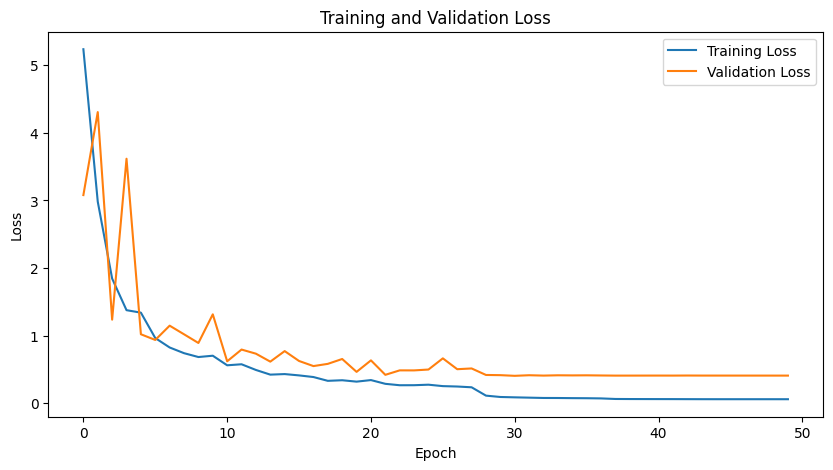

In [ ]:
# Commenting the below code as the model is trained separately with 50 epochs and stored in the drive!

# max_epochs = 50
# batch_size = 1

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# # device = torch.device("cpu")

# train_dataset = Dataclass(train_df)
# valid_dataset = Dataclass(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate, batch_size=1)
# model = Cigin()
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)


## RESULTS OF EXPERIMENT 2

In [ ]:
loaded_model = Cigin().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_exp2.tar'))
loaded_model.eval()
test_dataset = Dataclass(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate, batch_size=1)
loss, mae_loss = get_metrics(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 233/233 [00:07<00:00, 32.89it/s]


Loss :  0.3655949 
Mean Absolute Error Loss:  0.31940457 
Root Mean Square Error:  0.6046444


The second model yielded a final loss of 0.3655949, mean absolute error of  0.31940457, and root mean square error of 0.6046444 on the test set. See a figure of the loss of this model above. Note that both the training and validation loss slowly leveled out and became near-constant at approximately epoch 40, indicating that the model has reached close to its best possible performance.

# Results
## Results of Experiment 1 to prove Hypothesis 1:

RMSE of the model : 0.52 <br>
We acquired an RMSE of 0.52 which is improved over the baseline for the non-optimized model. Hence, Hypothesis 1 is proved right with experiment 1.

## Results of Experiment 2 to prove Hypothesis 2:

RMSE of the model : 0.605 <br>
RMSE reported in the paper : 0.57 <br>
This RMSE should be more than that obtained with model 1 from experiment 1, given that the first model is updated. Since 0.605 > 0.52, Hypothesis 2 is proved right.



## Model comparison

###COMPARING MODEL 1 WITH MODEL 2

As reported in the research paper [1], model 1 of experiment 1 gave better results compared to model 2 of experiment 2.

The difference lies in the model architecture and reduction in the model complexity. The two separate MPNN layers in model1 are replaced by using set2set layers for functions in both the message passing and prediction phase.

###COMPARING BOTH MODELS WITH BASELINE.

The baseline model yielded an RMSE of 0.65. Compared to that, both our models yielded improved results, similarly to the paper.

# Discussion

The source code from git repository referenced in the research paper, is reprodible with minor changes. The obtained results are very close and even better than what is reported in the paper.

Currently, we are facing difficulty in improving the training code by incorporating batching tachnique. This is particularly difficult with the code in experiment 2, as it is written to process each solute-solvent combination separately.

Parallelizing the code and using batching can improve the model training performance and might also add more validation credibility to the results.

In the next phase of the project, we will work of suggested improvement of model training along with woking on planned ablations. We will compare the performance of baseline model (model 2), with that of model 1(best model reported) and the models we get as result of ablation studies.

In conclusiosn, we aim to re-affirm the results reported in the research paper and work towards implementing any improvements in the model as and when possible.



# References

1.   Pathak, Y., Laghuvarapu, S., Mehta, S., & Priyakumar, U. D., [Chemically interpretable graph interaction network for prediction of pharmacokinetic properties of drug-like molecules.], [In Proceedings of the AAAI Conference on Artificial Intelligence], [2020], [Vol. 34]:[No. 01, pp. 873-880], doi: [https://doi.org/10.1609/aaai.v34i01.5433].

